In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('crypto-markets.csv'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

**Get our data**

In [6]:
# bring in data
df = pd.read_csv('crypto-markets.csv')

# isolate BTC
df = df
df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'crypto-markets.csv'

In [4]:
df.set_index('date')['close'].tail(500).plot(figsize=(15,4), title='BTC - close')

NameError: name 'df' is not defined

**Scale data**

In [4]:
# Use Scikit-learn to transform with maximum absolute scaling
from sklearn.preprocessing import MinMaxScaler,MaxAbsScaler

scaled_df = df.set_index('date')[['open','high','low','close']]

scaler = MaxAbsScaler()
scaler.fit(scaled_df)
scaled = scaler.transform(scaled_df)
scaled_df = pd.DataFrame(scaled_df, columns=scaled_df.columns)

# use first 1000 days as train
train = scaled_df[:1000]

# simulation window
window = 100 # days look ahead
test = scaled_df[1000:1000+window]

We will feed the model with our training data as the first 1000 days.

In [5]:
train.tail()

,open,high,low,close
date,,,,
2016-01-18,381.73,388.10,376.67,387.17
2016-01-19,387.03,387.73,378.97,380.15
2016-01-20,379.74,425.27,376.60,420.23
2016-01-21,419.63,422.88,406.30,410.26
2016-01-22,409.75,410.41,375.28,382.49


Then our predicted model will be compared against the test set, which captures 100 days into our observed future.

In [6]:
test.head()

,open,high,low,close
date,,,,
2016-01-23,382.43,394.54,381.98,387.49
2016-01-24,388.10,405.48,387.51,402.97
2016-01-25,402.32,402.32,388.55,391.73
2016-01-26,392.00,397.77,390.58,392.15
2016-01-27,392.44,396.84,391.78,394.97


**Initiate VARMAX Modeling**

As well as, output model summary for each variable [o,h,l,c].

In [7]:
# VARMA example
from statsmodels.tsa.statespace.varmax import VARMAX

# contrived dataset
data = train[['open','high','low','close']]
# fit model
model = VARMAX(data, freq = 'D', order=(1,1), seasonal_order=(0, 0, 0, 0),
                mle_regression = True,
                filter_concentrated = True)
model_fit = model.fit(disp=True)

# make prediction
yhat = model_fit.predict(len(data), len(data))

from IPython.display import clear_output
clear_output()

model_fit.summary()

Dep. Variable:,"['open', 'high', 'low', 'close']",No. Observations:,1000
Model:,"VARMA(1,1)",Log Likelihood,-13897.575
,+ intercept,AIC,27889.149
Date:,"Sun, 20 Mar 2022",BIC,28119.814
Time:,01:43:57,HQIC,27976.818
Sample:,04-28-2013,Scale,0.983
,- 01-22-2016,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"0.79, 0.02, 0.10, 0.04",Jarque-Bera (JB):,"41137.08, 47795.29, 147101.85, 30399.93"
Prob(Q):,"0.37, 0.89, 0.75, 0.85",Prob(JB):,"0.00, 0.00, 0.00, 0.00"
Heteroskedasticity (H):,"0.27, 0.13, 0.06, 0.13",Skew:,"1.71, 3.72, -6.01, 0.78"


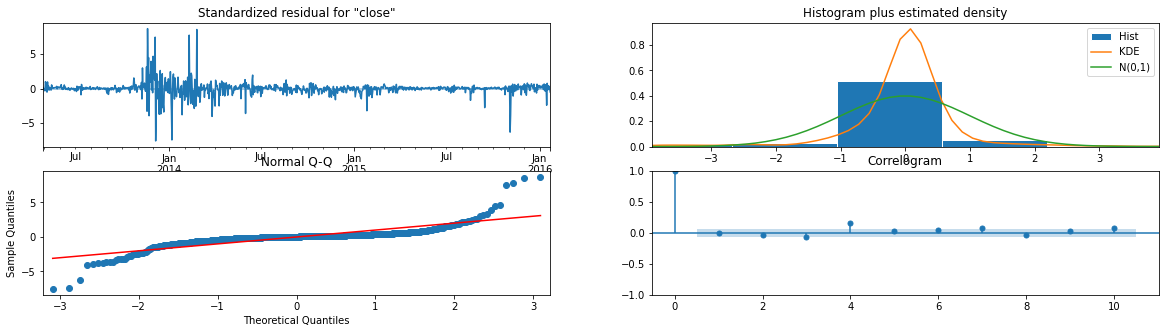

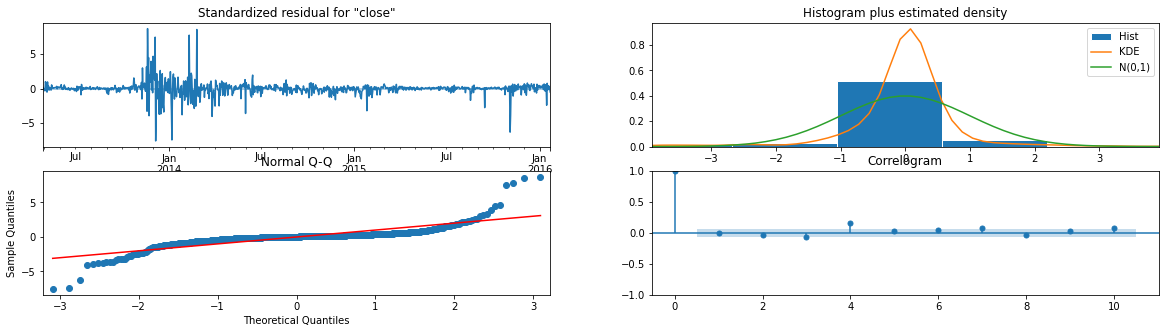

In [8]:
# simulate prediction
model_fit.plot_diagnostics(3,figsize=(20,5))

<AxesSubplot:title={'center':'prediction vs observed'}>

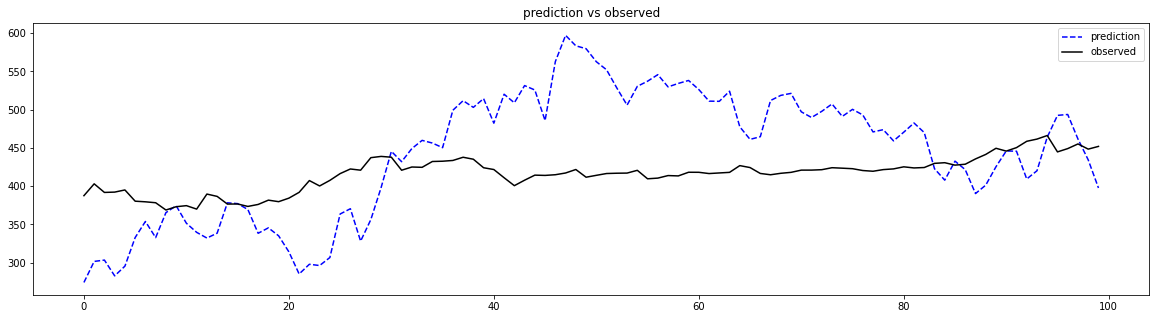

In [9]:
# plot
pred = pd.DataFrame()
pred['prediction'] = model_fit.simulate(window).reset_index(drop=True).close
pred['observed'] = test.reset_index(drop=True).close
pred.plot(figsize=(20,5),title='prediction vs observed',color=['blue','black'],style=['--','-'])

**Plot prediction - observed**

<AxesSubplot:title={'center':'forecast error'}>

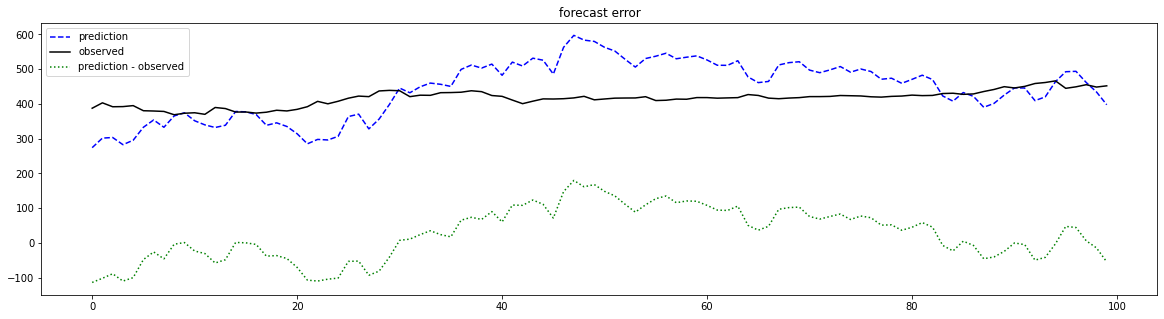

In [10]:
pred['prediction - observed'] = pred['prediction'] - pred['observed']
pred.plot(figsize=(20,5),title='forecast error',color=['blue','black','green'],style=['--','-',':'])